In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import random
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from skimage.util.shape import view_as_windows
from scipy.interpolate import CubicSpline      # for warping
import seaborn as sns
from dataclasses import dataclass

!pip install transforms3d
from transforms3d.axangles import axangle2mat  # for rotation
from google.colab import files

from google.colab import drive
drive.mount('/content/drive/')
import windowing as W
import Experiments_toolkit as EXTK
import DataAugmentation as DA
import plotting_util as PLOT



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
def plot(matrix):
  # matrix must be one sample:  4D with x, y, z, nanos (DATA[key][0])
  x = matrix['x']
  y = matrix['y']
  z = matrix['z']
  nanos = matrix['nanos'] 
  plt.plot(nanos, x,'r' ,nanos, y,'b', nanos, z,'palegreen')
  plt.show()

In [4]:
def graph_numpy(array):
  x = array[0]
  y = array[1]
  z = array[2]
  plt.plot(x,'r' , label = "x-axis")
  plt.plot(y,'b',label="y-axis")
  plt.plot(z,'palegreen', label = "z-axis")
  plt.legend(loc='best', prop={"size":10})
  plt.xlabel("Time", size= 18)
  plt.ylabel("Accleration", size= 18)
  plt.show()

#**Importing Data**#
Import the sensor data and configure each sample to a numpy array as seen below. The numpy array can have any number of features as long as the last row is for time. If there is no time data, the last row can simply hold the indices for the data. 

Numpy Array: ```[X, Y, Z, ... , time]```

In the example below, we use sensor data from [this study](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer)  that includes 14 simple tasks that participants did with a wrist-worn accelerometer. In the set-up process, we transform the data into a numpy array and then store it in a dictionary with an appropriate action key.

In [5]:
STANDUP_CHAIR_PATH = '/content/drive/My Drive/Colab Notebooks/HMP_Dataset/Standup_chair/'
WALK_PATH = '/content/drive/My Drive/Colab Notebooks/HMP_Dataset/Walk/'
standup_chair = "STANDUP_CHAIR"
walk = "WALK"
DATA = {standup_chair : [], walk: []}

##**Set-Up:**##

The number of feautures should be constant throughout the data samples but the number of data points for each trace may vary

In [6]:

for file in os.listdir(STANDUP_CHAIR_PATH):
    if file.endswith(".txt"):
        df = pandas.read_table(STANDUP_CHAIR_PATH + file, delim_whitespace=True, names=['X', 'Y', 'Z'])
        df['X'] = df['X'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Y'] = df['Y'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Z'] = df['Z'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['id'] = df.index
        x = df.to_numpy().transpose()
        DATA[standup_chair].extend([x]) # SHAPE = (# of features, timesteps) 
x.shape

(4, 287)

In [7]:
for file in os.listdir(WALK_PATH):
    if file.endswith(".txt"):
        df = pandas.read_table(WALK_PATH + file, delim_whitespace=True, names=['X', 'Y', 'Z'])
        df['X'] = df['X'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Y'] = df['Y'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Z'] = df['Z'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['id'] = df.index
        x = df.to_numpy().transpose()
        DATA[walk].extend([x]) # SHAPE = (# of features, timesteps) 
x.shape

(4, 1050)

##**Initialize Parameters**##
```
@dataclass
class Initial_Filtering_Params:
    window_size: int
    stride: int
    divisor: int
    rows: int 

@dataclass
class Precise_Filtering_Params:
    window_size: int
    stride: int
    threshold: int
    rows: int

@dataclass
class All_Filtering_Params:
    initial_filtering: Initial_Filtering_Params
    precise_filtering: Precise_Filtering_Params
```

To set parameters for the multi-resolution windowing algorithm, we instansiate dataclasses with the parameters we will need. I have chosen parameters that work with the dataset being used, but these will likely change based on the shape and size of the data it is being used on. Adjusting the parameters is more of an art than a science. These parameters will change how the start and end times are calcualted on the sensor data, so adjust them until. 



In [8]:
params1 = W.Initial_Filtering_Params(window_size = 25, stride = 5, divisor = 10, rows = 4)
params2 = W.Precise_Filtering_Params(window_size = 6, stride = 1, threshold = 1, rows = 4)
filtering_params = W.All_Filtering_Params(params1, params2)

Iterate over the numpy arrays in DATA["STANDUP_CHAIR"] and print out the accelerometer data with the calculated start and end times:

In [9]:
rows = 4

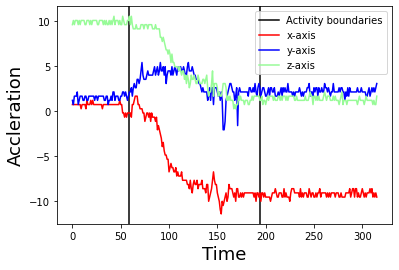

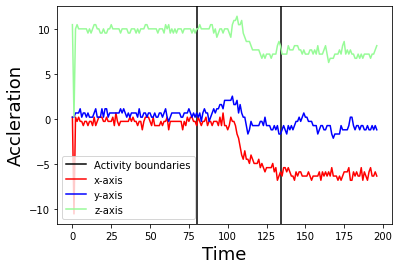

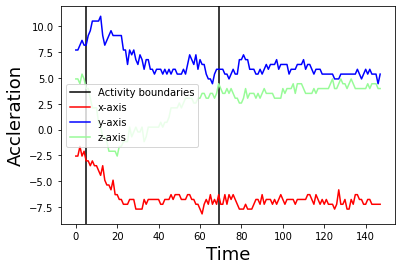

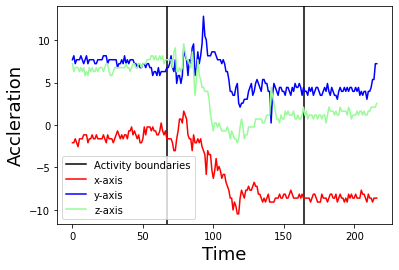

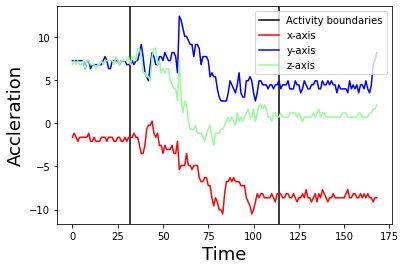

In [10]:
for j in range(5):
    sample = DATA[standup_chair][j]
    activity_windows = W.initial_find_activity(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(activity_windows) > 0:
        start_time, end_time = W.get_start_time(activity_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)

        plt.axvline(x=start_time, color = 'black')
        plt.axvline(x=end_time, color = 'black', label = "Activity boundaries")
        graph_numpy(sample)


###**Graph Walking Data**
* to take a look at the shape of the walking data we can graph a few of the traces

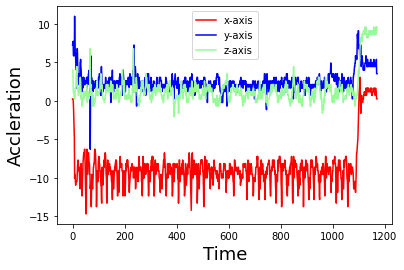

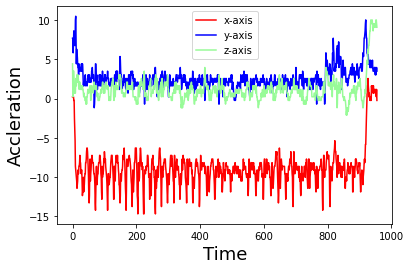

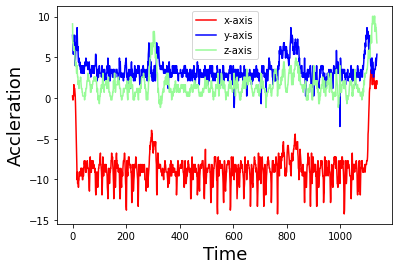

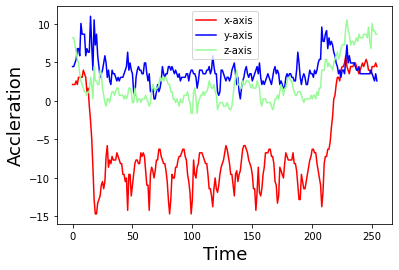

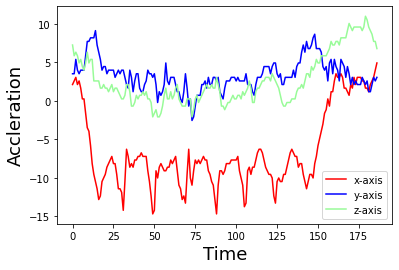

In [11]:
for j in range(5):
    sample = DATA[walk][j]
    graph_numpy(sample)

#**Histogram of Activity Length**#
To know how long the activity of standing up from a chair takes, we will create a histogram or the activity length to better understand the data. 

In [12]:
rows = 4
activity_length = []
for j in range(len(DATA[standup_chair])):
    sample = DATA[standup_chair][j]
    activity_windows = W.initial_find_activity(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(activity_windows) > 0:
        start_time, end_time = W.get_start_time(activity_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        activity_time = end_time - start_time
        activity_length.append(activity_time)

Number of sample:  102
DescribeResult(nobs=102, minmax=(32.0, 264.0), mean=91.15686274509804, variance=984.3315860997864, skewness=2.002397543387474, kurtosis=7.9013059295494035)


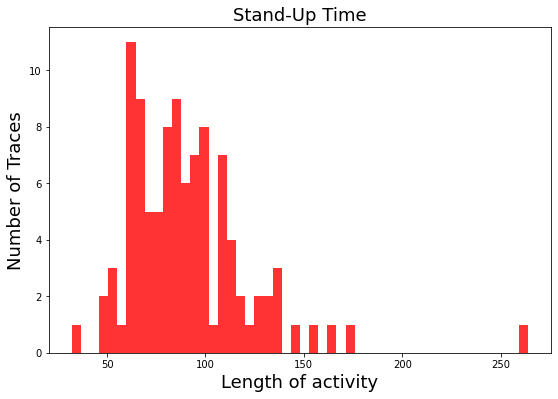

In [13]:
print("Number of sample: ", len(activity_length))
plt.figure(figsize=(9,6))
plt.hist(activity_length, 50, facecolor='red', alpha=0.8)
plt.title("Stand-Up Time", size = 18)
plt.xlabel("Length of activity", size= 18)
plt.ylabel("Number of Traces", size = 18)
print(stats.describe(activity_length))

#**Different Windows**
After finding the start and end times of the activity, we may want to use this information to create windows of a set size that will be useful. In this library, there are 2 window creating functions:
* ```get_window_from_timestamp(np_sample, start_time, window_size)```
* ```centered_window(np_sample, center_time, window_size)```

These functions return return ``` int[] ``` with windows of all the same size, thus is very useful for preprocessing traces to be used in t-SNE, PCA, etc. calculations along with machine learning. Another thing to note is that these functions will wrap around and balance themselves within the trace so the size of the windows will = ```window_size``` 


**Use Case**
* experiments with the affect of different windows on model accuracy 
* show which parts of the data is most impactful when classifying different activities


###**Centered Window**
* the ```offset``` is added to the center point time of the window so that you can easily affect the sliding of the window along the trace
* the ```window_size``` refers to number of data points in one window

This function creates a window centered around a specific time and always gaurentees that the resulting window will have length = ```window_size``` unless ```window_size > length of the trace``` in which case the function returns the whole trace unaltered. Below, I have graphed a few windows to show how the function behaves on the traces. 

In [14]:
WINDOW_SIZE = 40
OFFSET = 0

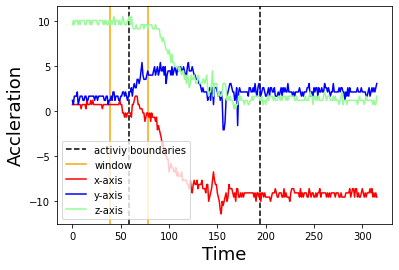

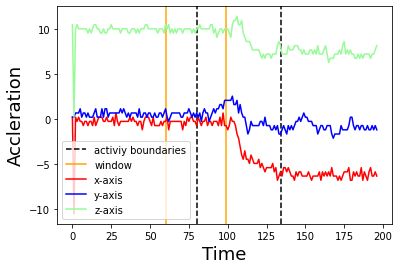

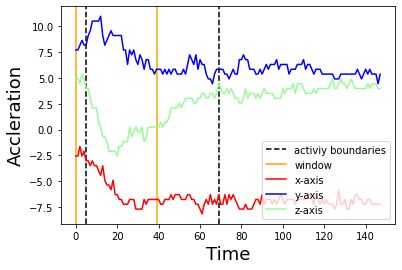

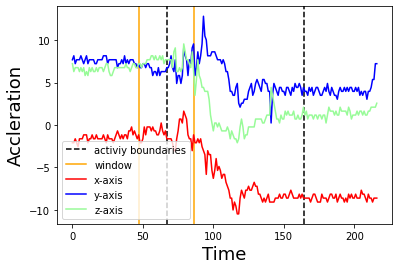

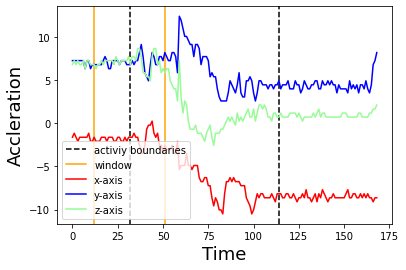

In [15]:
for j in range(5):
    sample = DATA[standup_chair][j]
    activity_windows = W.initial_find_activity(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(activity_windows) > 0:
        start_time, end_time = W.get_start_time(activity_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        center_window = W.centered_window(
            sample, start_time + OFFSET, WINDOW_SIZE)
        
        plt.axvline(x=start_time, linestyle='dashed', color = 'black', label = "activiy boundaries")
        plt.axvline(x=end_time, linestyle='dashed', color = 'black')
        plt.axvline(x=center_window[0][-1][0], color = 'orange', label = "window")
        plt.axvline(x=center_window[0][-1][-1], color = 'orange')
        graph_numpy(sample)
       

To streamline this process more, the ```preprocess_data``` function some the same thing as the code above and returns ```int[]```

In [16]:
center_windows = EXTK.preprocess_data(DATA[standup_chair], rows, filtering_params, W.centered_window, WINDOW_SIZE, OFFSET)
center_windows.shape # SHAPE = (num of windows, num of dimension, num of samples)

(102, 4, 40)

One could also simply iterate over the traces as numpy arrays and call ```centered_window(np_sample, center_time, window_size):``` with the desired center point. We chose to have the ```start_time``` of the activity hard coded into ```preprocess_data``` because it was very useful to our experiments.

###**Window from Timestamp**
* creates windows from the trace from a given timestamp
* the function wraps around so that windows = ```window_size``` are always returned unless ```len(sample) < window_size``` 
* ```centered_windows``` and ```get_window_from_timestamp``` can be used interchangeably to produce different 

In [17]:
WINDOW_SIZE = 40
OFFSET = 0

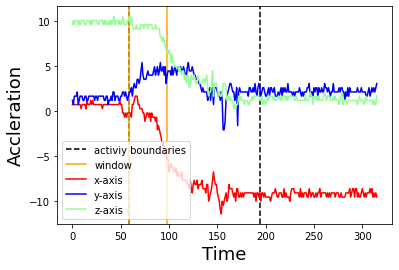

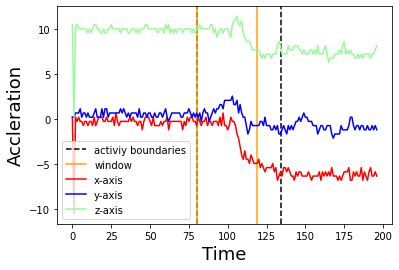

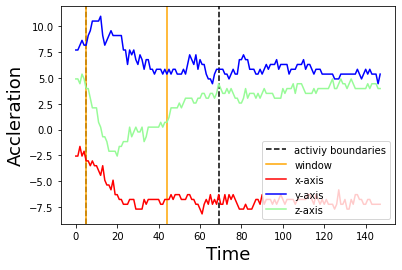

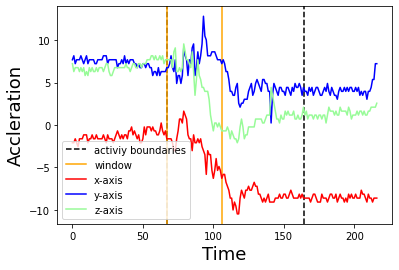

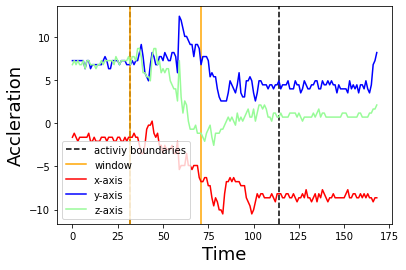

In [18]:
for j in range(5):
    sample = DATA[standup_chair][j]
    activity_windows = W.initial_find_activity(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(activity_windows) > 0:
        start_time, end_time = W.get_start_time(activity_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        center_window = W.get_window_from_timestamp(
            sample, start_time + OFFSET, WINDOW_SIZE)
        
        plt.axvline(x=start_time, linestyle='dashed', color = 'black', label = "activiy boundaries")
        plt.axvline(x=end_time, linestyle='dashed', color = 'black')
        plt.axvline(x=center_window[0][-1][0], color = 'orange', label = "window")
        plt.axvline(x=center_window[0][-1][-1], color = 'orange')
        graph_numpy(sample)
       

In [19]:
windows_from_timestamp = EXTK.preprocess_data(DATA[standup_chair], rows, filtering_params, W.get_window_from_timestamp, WINDOW_SIZE, OFFSET)
windows_from_timestamp.shape # SHAPE = (num of windows, num of dimension, num of samples)

(102, 4, 40)

#**Plotting**
Below are helpful functions that set up t-SNE, PCA, and ICA plots. These plots can be very useful because they can plot non-2D data on a 2D graph for easy visualization. These visualization can help us see clusterings in our data and ultimately can tell us realtivley how easy 2 or more sets of data will be to differentiate. The more distinct the clustering, the easier these may be to differentiate when using a classification model. We need to preprocess the data before plotting. We need to create 2 numpy arrays of the data we want to compare, and then call the ```get_np_X_Y``` function that will return: 
```
X -- numpy array : [data_type_1 , data_type_2]
Y -- numpy array : [1,1,1,...,1, 0,0,0,...,0]
```

In this example, we will compare STANDUP_CHAIR data and WALK data. We will compare the ```windows_from_timestamp``` and ```center_windows``` from STANDUP_CHAIR with windows of the same size from the WALK dataset.

In [20]:
WINDOW_SIZE = 60

In [21]:
STANDUP_CHAIR_windows =  EXTK.preprocess_data(DATA["STANDUP_CHAIR"], rows, filtering_params, W.get_window_from_timestamp, WINDOW_SIZE, OFFSET)
STANDUP_CHAIR_center_windows =  EXTK.preprocess_data(DATA["STANDUP_CHAIR"], rows, filtering_params, W.get_window_from_timestamp, WINDOW_SIZE, OFFSET)
WALK_windows = EXTK.preprocess_data(DATA["WALK"], rows, filtering_params, W.create_windows_of_size, WINDOW_SIZE, OFFSET)

In [22]:
num_samples = 100

In [23]:
start_time_windowsX, start_time_windowsY = EXTK.get_np_examples_labels(STANDUP_CHAIR_windows[:, :3], WALK_windows[:, :3], num_samples) 
# only want the first 3 dimensions of the sensor features 
print(start_time_windowsY.shape)
print(start_time_windowsX.shape)

(200,)
(200, 3, 60)


In [24]:
center_windowsX, center_windowsY = EXTK.get_np_examples_labels(STANDUP_CHAIR_center_windows[:, :3], WALK_windows[:, :3], num_samples) 
print(center_windowsY.shape)
print(center_windowsX.shape)

(200,)
(200, 3, 60)


In order to send ```compareX``` through the sklearn TSNE function, the array needs to be reshaped to only 2 dimension: 

In [25]:
sample, x, y = start_time_windowsX.shape
start_time_windowsX = start_time_windowsX.reshape((sample, x*y))
print(start_time_windowsX.shape)

(200, 180)


In [26]:
sample, x, y = center_windowsX.shape
center_windowsX = center_windowsX.reshape((sample, x*y))
print(center_windowsX.shape)

(200, 180)


Here, will plot Walking vs Standup_chair (windows from start time) and Walking vs Standup_chair (windows centered at start time ) on each type of plot. We can then look at the plots to see which type of window makes the Stanup_chair look the most different from the walking data. 

In [27]:
ALPHA = 0.6

##**t-SNE**
* t-SNE plotting function takes in :
```
 type_1 -- numpy array
 type_2 -- numpy array
  alpha -- int ( transparency level of the dots on the plot )
 ```

This funciton will plot the 2 different sets of data passed into it. With the plotting function, the ```type_1``` is considered ```positive``` and ```type_2``` is considered ```negative```

In [28]:
n_components = 3 # Number of features 

###**Windows from Start** 

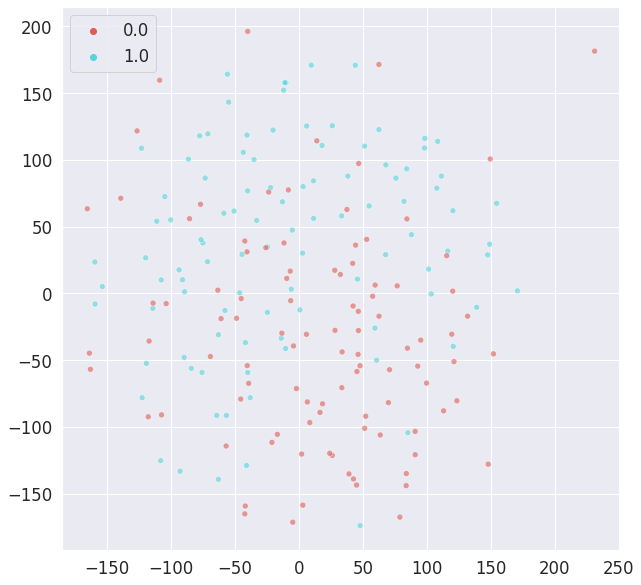

In [29]:

PLOT.scatter_TSNE(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

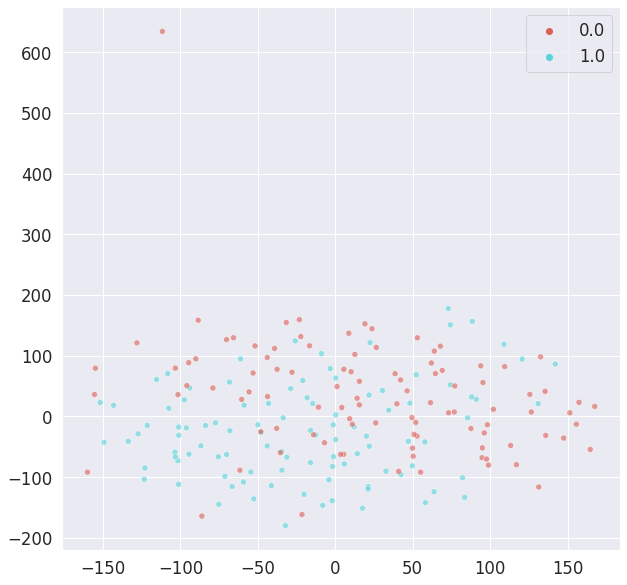

In [30]:
PLOT.scatter_TSNE(center_windowsX, center_windowsY, n_components, ALPHA)

##**PCA**

###**Windows from Start** 

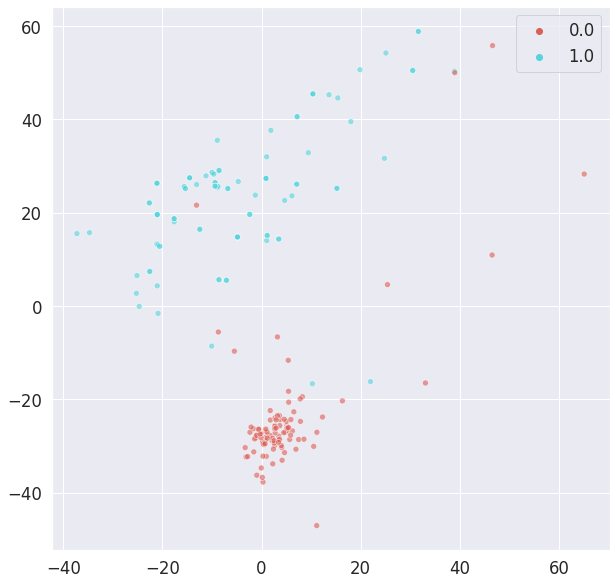

In [31]:
PLOT.scatter_PCA(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

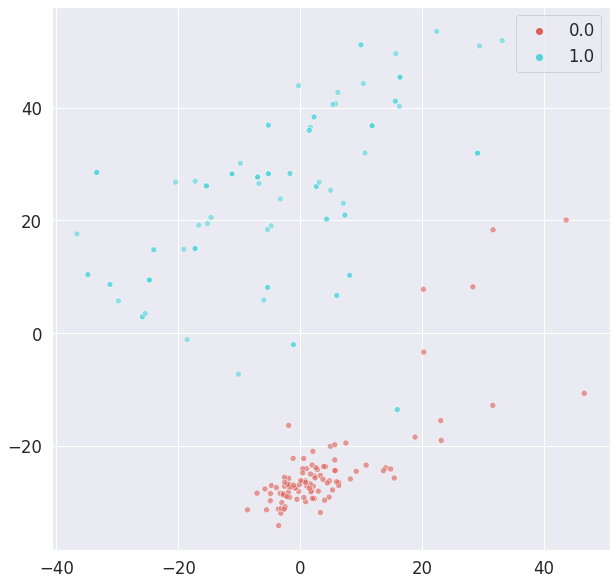

In [32]:
PLOT.scatter_PCA(center_windowsX, center_windowsY, n_components, ALPHA)

##**ICA**

###**Windows from Start** 

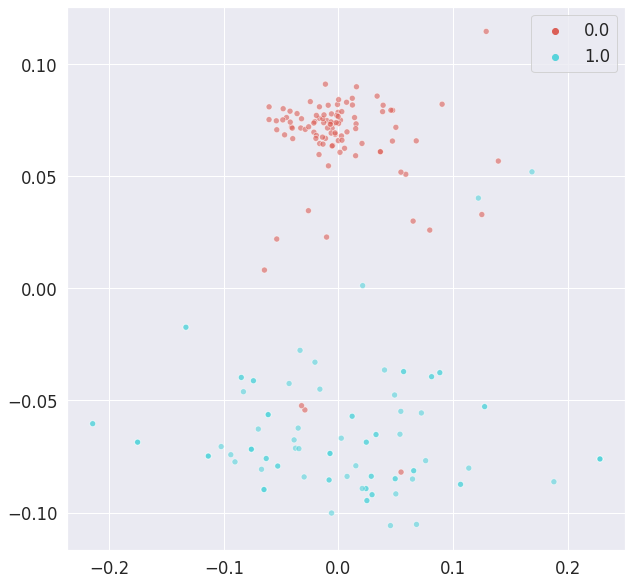

In [33]:
PLOT.scatter_ICA(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

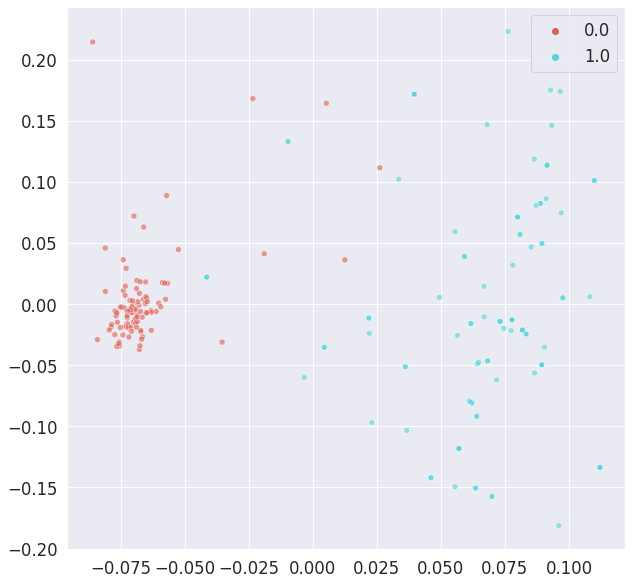

In [34]:
PLOT.scatter_ICA(center_windowsX, center_windowsY, n_components, ALPHA)

From the plots, we can tell that the Standup_chair with ```windows centered at Start``` generally have a better and more distinct clustering. This tells us that these types of windows might have a better accuracy when used in a classification model. Of course, this is not a hard and fast rule, these plots are still useful to give us more intuition about the data we are working with. 

#**ML Experiments: Classification**
Below, we will set up a simply classification model that will predict if a window contains the action of standing up from a chair or if the window contains the action of walking. 

##**Centered Windows**##

* create a train, test, and validation dictionaries each with a ```"positives"``` and ```"negatives"``` key 
* Numpy arrays of the randomized windows are stored at the keys

Ex:
```
train= { "positives" : [np_array_of_windows], 
         "negatives" : [np_array_of_windows]}
```

In [35]:
MAX_SAMPLES = 100

percent_train = 0.6
percent_test = 0.2
percent_validation = 0.2

When creating the train, test, and validation dictionaries we do not want to include the timeseries data. So, we just use ```data[:, :3]```

In [36]:
train, test, validation = EXTK.create_train_test_validation(STANDUP_CHAIR_center_windows[:, :3], WALK_windows[:, :3], percent_train, percent_test, percent_validation)

The ```create_dataset``` method returns a ```tf.data.Datatset```

In [37]:
train_dataset = EXTK.create_dataset(train["positives"], train["negatives"], MAX_SAMPLES)
train_dataset

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [38]:
validation_dataset = EXTK.create_dataset(validation["positives"], validation["negatives"], MAX_SAMPLES)
validation_dataset

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [40]:
test_examples, test_labels = EXTK.get_np_examples_labels(test["positives"], test["negatives"], MAX_SAMPLES)
print(test_examples.shape)

(40, 3, 60)


###Batch and Shuffle

In [41]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset_SHUFFLED = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset_SHUFFLED = validation_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

###Build Model

In [133]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3, 60)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(1)
])

In [134]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [135]:
model.fit(train_dataset_SHUFFLED, epochs = 15, validation_data=validation_dataset_SHUFFLED)

Epoch 1/15
2/2 [==============================] - 0s 54ms/step - loss: 2.1014 - accuracy: 0.4426 - val_loss: 0.4595 - val_accuracy: 0.8571
Epoch 2/15
2/2 [==============================] - 0s 7ms/step - loss: 1.0497 - accuracy: 0.6230 - val_loss: 0.2415 - val_accuracy: 0.9524
Epoch 3/15
2/2 [==============================] - 0s 7ms/step - loss: 0.5869 - accuracy: 0.7951 - val_loss: 0.1560 - val_accuracy: 0.9286
Epoch 4/15
2/2 [==============================] - 0s 7ms/step - loss: 0.4411 - accuracy: 0.8443 - val_loss: 0.1441 - val_accuracy: 0.9524
Epoch 5/15
2/2 [==============================] - 0s 8ms/step - loss: 0.3889 - accuracy: 0.8852 - val_loss: 0.1563 - val_accuracy: 0.9524
Epoch 6/15
2/2 [==============================] - 0s 8ms/step - loss: 0.2775 - accuracy: 0.9262 - val_loss: 0.1679 - val_accuracy: 0.9524
Epoch 7/15
2/2 [==============================] - 0s 8ms/step - loss: 0.3612 - accuracy: 0.8934 - val_loss: 0.1739 - val_accuracy: 0.9524
Epoch 8/15
2/2 [=================

###Test Model

In [136]:
test_loss, test_acc = model.evaluate(test_examples, test_labels, verbose=1) 
print('Test accuracy:', test_acc, "\n")

2/2 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9750
Test accuracy: 0.9750000238418579 



##**Windows from Start Time**##

Now we will run the same ML experiment using the windows from the start time of the activity. We will use the same model architecture for consistancy in the experiment. We can compare the accuracy of both of these experiments to determine which window type is best for deciding whether the activity is taking place in a given window or not. 

We will set up the second experiment exactly the same at the first by first creating the train, test, and validation sets. 

In [50]:
train_2, test_2, validation_2 = EXTK.create_train_test_validation(STANDUP_CHAIR_windows[:, :3], WALK_windows[:, :3], percent_train, percent_test, percent_validation)

In [51]:
train_dataset_2 = EXTK.create_dataset(train_2["positives"], train_2["negatives"], MAX_SAMPLES)
train_dataset_2

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [52]:
validation_dataset_2 = EXTK.create_dataset(validation_2["positives"], validation_2["negatives"], MAX_SAMPLES)
validation_dataset_2

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [53]:
test_examples_2, test_labels_2 = EXTK.get_np_examples_labels(test_2["positives"], test_2["negatives"], MAX_SAMPLES)
print(test_examples_2.shape)

(40, 3, 60)


In [54]:
test_examples_2, test_labels_2 = EXTK.get_np_examples_labels(test_2["positives"], test_2["negatives"], MAX_SAMPLES)
print(test_examples_2.shape)

(40, 3, 60)


###Batch and Shuffle

In [109]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset_SHUFFLED_2 = train_dataset_2.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset_SHUFFLED_2 = validation_dataset_2.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

###Build Model

In [115]:
model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(3, 60)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(1)
])

In [116]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [117]:
model_2.fit(train_dataset_SHUFFLED_2, epochs = 15, validation_data=validation_dataset_SHUFFLED_2)

Epoch 1/15
2/2 [==============================] - 0s 54ms/step - loss: 2.4690 - accuracy: 0.4836 - val_loss: 0.9692 - val_accuracy: 0.4524
Epoch 2/15
2/2 [==============================] - 0s 8ms/step - loss: 1.0889 - accuracy: 0.7049 - val_loss: 0.5340 - val_accuracy: 0.8095
Epoch 3/15
2/2 [==============================] - 0s 7ms/step - loss: 0.5942 - accuracy: 0.7295 - val_loss: 0.6115 - val_accuracy: 0.8810
Epoch 4/15
2/2 [==============================] - 0s 9ms/step - loss: 0.5212 - accuracy: 0.7459 - val_loss: 0.5549 - val_accuracy: 0.8810
Epoch 5/15
2/2 [==============================] - 0s 7ms/step - loss: 0.3472 - accuracy: 0.8443 - val_loss: 0.4816 - val_accuracy: 0.9048
Epoch 6/15
2/2 [==============================] - 0s 8ms/step - loss: 0.3314 - accuracy: 0.8361 - val_loss: 0.4251 - val_accuracy: 0.9048
Epoch 7/15
2/2 [==============================] - 0s 7ms/step - loss: 0.2095 - accuracy: 0.9016 - val_loss: 0.3830 - val_accuracy: 0.9048
Epoch 8/15
2/2 [=================

###Test Model

In [118]:
test_loss_2, test_acc_2 = model_2.evaluate(test_examples_2, test_labels_2, verbose=1) 
print('Test accuracy:', test_acc_2, "\n")

2/2 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9250
Test accuracy: 0.925000011920929 



##**Analysis**

The exact accuracy rates can vary every time we re-compile the model and run it again, but we should see that the **Centered Windows** is gerneally outperforming the **Windows at Start Time**. From this we can conclude that the **Centered windows** are better for determining if an activity is happening in a given window that the **Windows at Start Time**. For further research, it may be a good idea to try and optimize a model individually for both types of windows to see which type of window can reach the highest accuracy rates possible, but for the sake of brevity in this experiment we will not run the numerous other experiments fine-tuning the hyper-parameters of the models. 



#**Data Augmentation**

The data augmentation funtions take a numpy array with shape = ```(length_of_samples, dimensions)``` so in this case we need to tranpose the data if we are calling any ```DA_(augment)``` function indepently of the ```preprocess_with_augmentation``` function which handles the transposition. When using these augmentation functions, we normally just specify the ```sigma``` which is used to calculate how big of a change to apply to the trace, but everytime we run the augmentation functions they randomize the augment where ```sigma``` is the upper bound. Thus the augmentations will be different each time even if run on the same trace. 

Data augmentation can be very useful to generate more usable and trainable data from the original set of data. By augmenting the data we already have, we can "reuse" the original data by making it different enough to be seen as "new". 

One use case of this is when we do not have a large dataset and want to increase the size of our dataset by augmenting samples we already have and adding these to our data. This may help us train a model mor accureatly because it is seeing more data and different data. 

In [60]:
SAMPLE = np.array(DATA["STANDUP_CHAIR"][0][:3])

##**Jittering**

**Hyper Parameters = SIGMA**

In [61]:
SIGMA = 0.5

NO AUGMENT


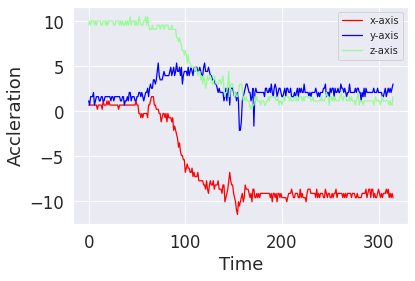

In [62]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

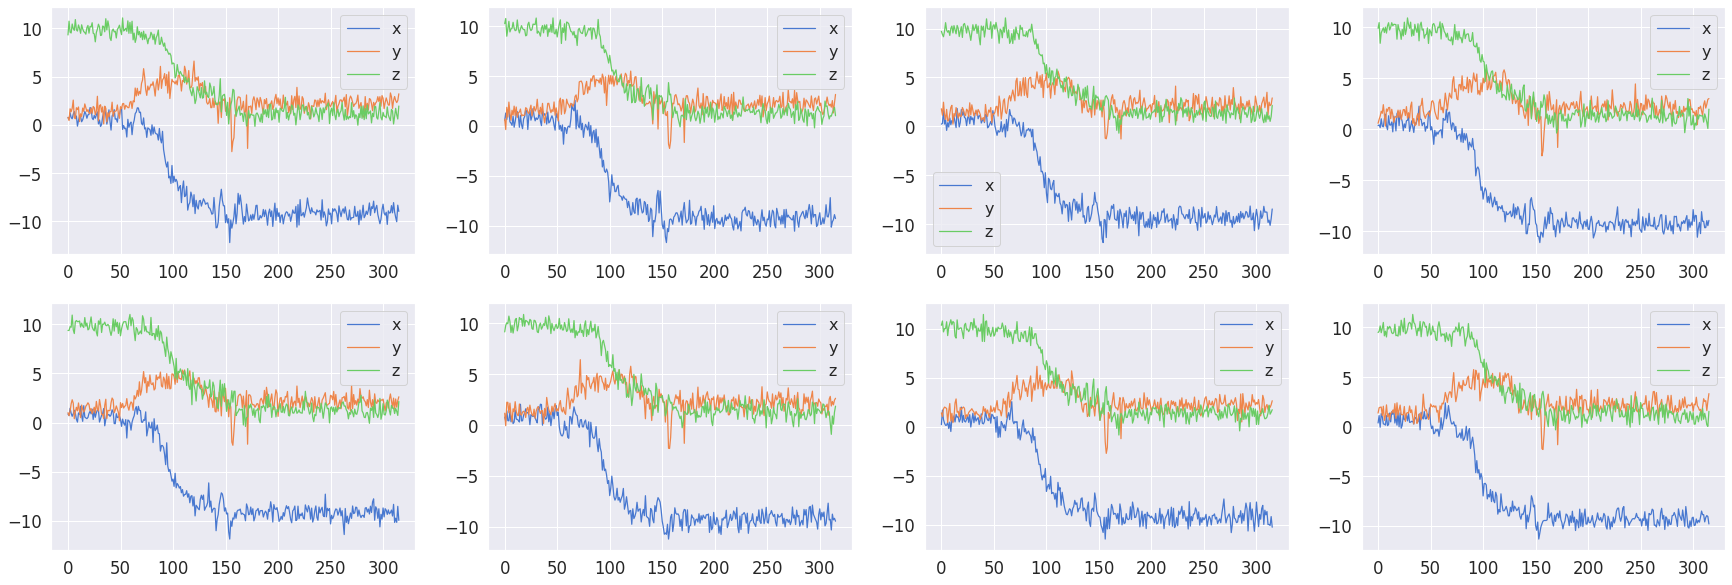

In [64]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA.DA_Jitter(SAMPLE.transpose(), SIGMA))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

* Increasing **SIGMA** will increase the amount of jittering in the trace




Use ```preprocess_with_augemtation``` to get a list of all the traces with the desired augments:

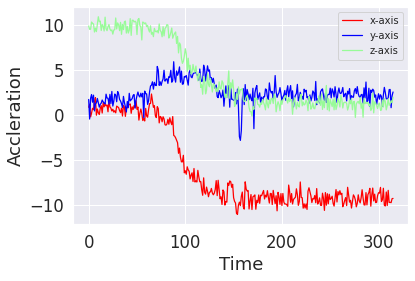

In [66]:
standup_chair_JITTERED = EXTK.preprocess_add_augmentation(DATA["STANDUP_CHAIR"], DA.DA_Jitter, SIGMA)

graph_numpy(standup_chair_JITTERED[0])

##**Time Warping**


Time warping the sample will split up the trace into equally sized windows and then changes the frequency of the samples within these windows. This gives the affect of "warping" different parts of the trace at different rates. 

In [67]:
SIGMA = 0.5

NO AUGMENT


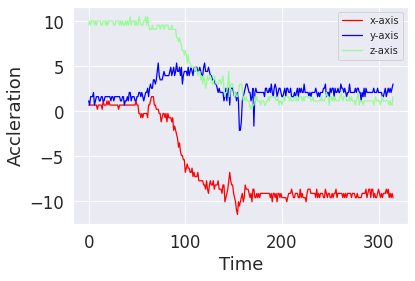

In [68]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

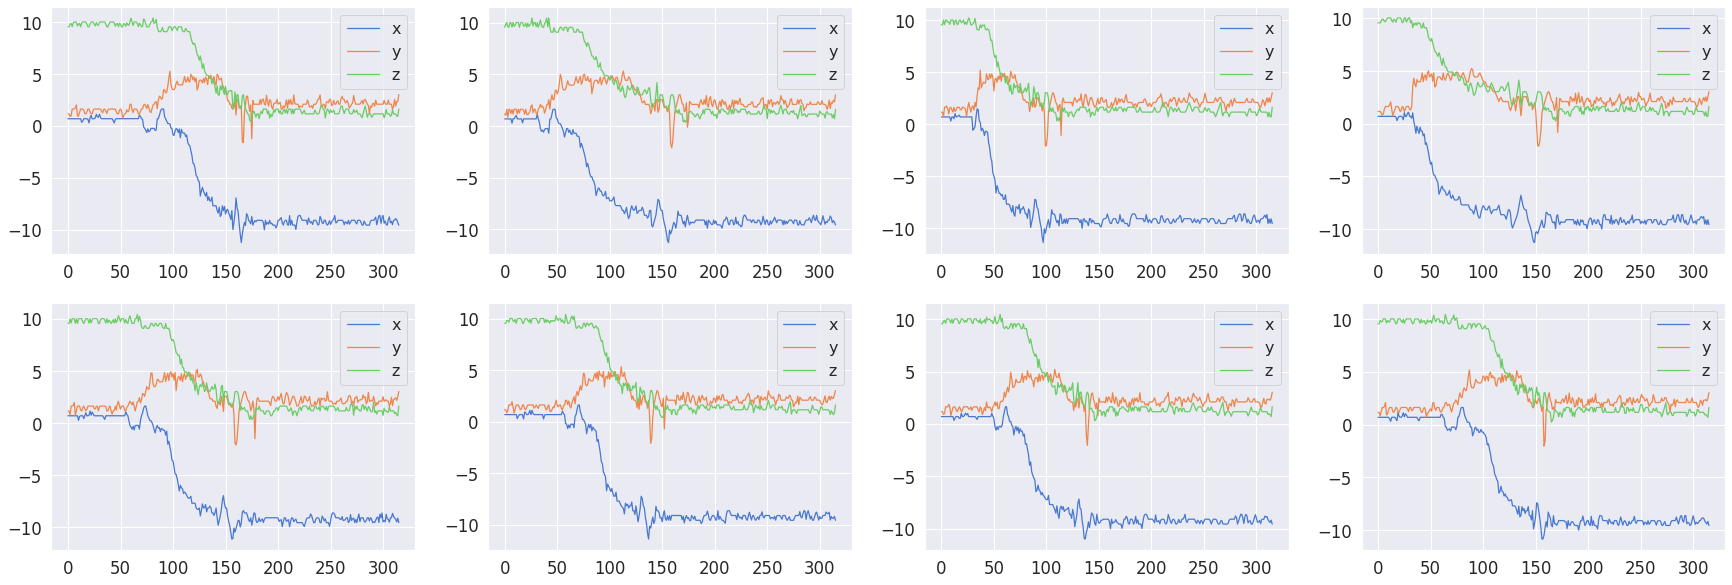

In [69]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA.DA_TimeWarp(SAMPLE.transpose(), SIGMA))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

Again we can use ```preprocess_with_augmentation``` function to apply these augmentations to all traces in a list. 

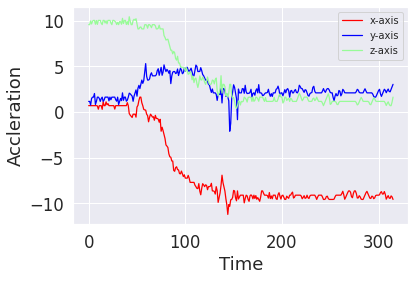

In [70]:
standup_chair_TIMEWARP = EXTK.preprocess_add_augmentation(DATA["STANDUP_CHAIR"], DA.DA_TimeWarp, SIGMA)

graph_numpy(standup_chair_TIMEWARP[0])

##**Rotation**


###**Random Rotation**

The rotation function ```DA_Rotation``` does not have a ```sigma``` as a parameter and gerenates the axis of rotation and also the angle of rotation. 

NO AUGMENT


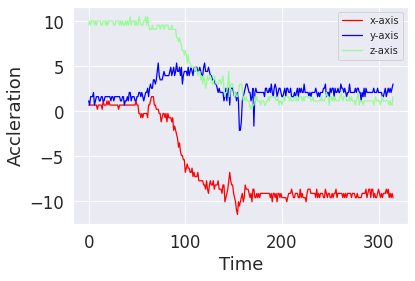

In [71]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

Rotation


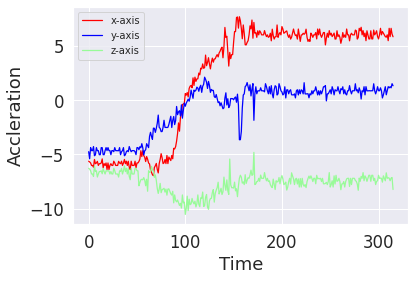

In [72]:
rotated_sample = DA.DA_Rotation(SAMPLE.transpose()).transpose()
print("Rotation")
graph_numpy(rotated_sample)

To make this clearer, below we run the ```DA_Rotation``` function on the same trace to show how the randomization of the axis and angle of rotation affect the trace:

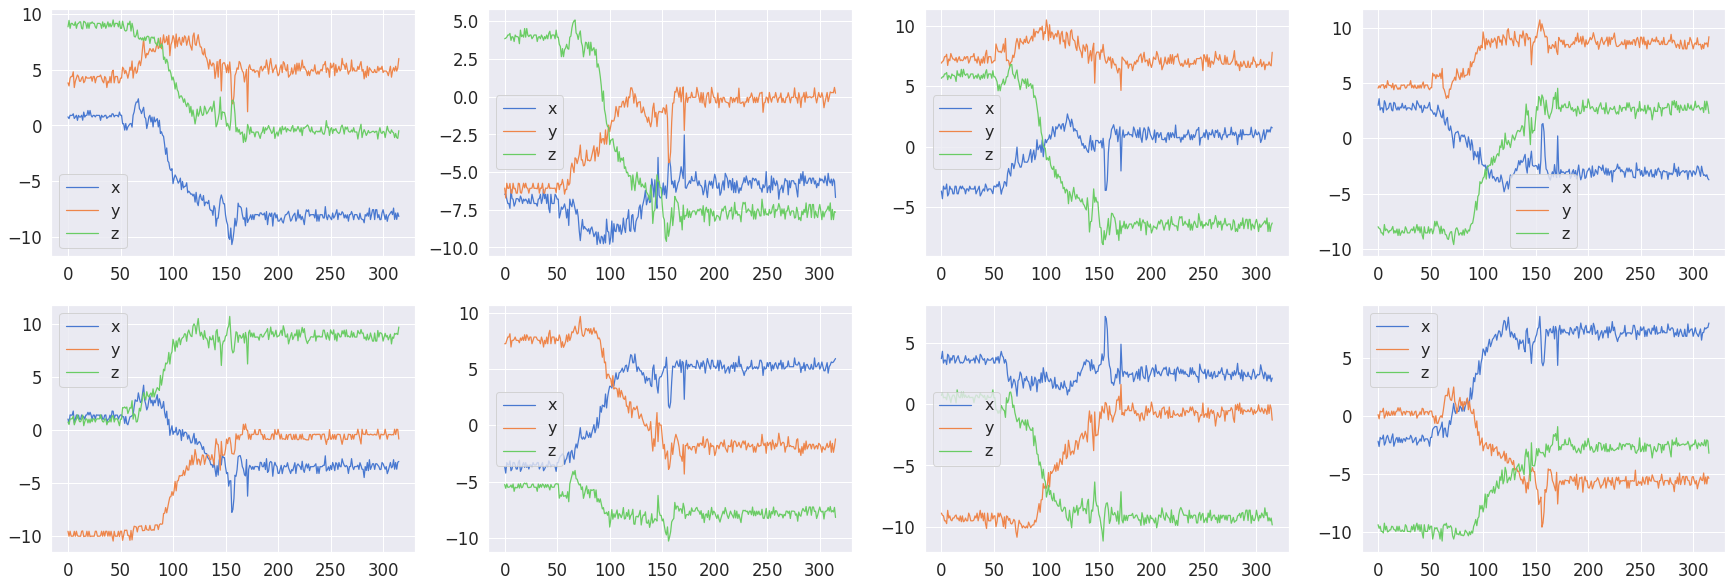

In [73]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA.DA_Rotation(SAMPLE.transpose()))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

###**Specific Rotation**

We can also use the function ```DA_Rotation_specific``` to specify a certain axis and angles of rotation. 

*   ```DA_Rotation_specific(X, angle_low, angle_high, axis)```
    * ```angle_low, angle_high : radians```
    * ```axis : numpy array, for each axis assign a value to determine how it will be rotated, SHAPE = (3). ```
        * Ex: if our data is structured as ```[x, y, z]``` if ```axis = [1.0, 0, 0]``` then the rotations will only be around the ```x``` axis. 





In [74]:
AXIS = np.array([1.0, 0, 0]) # rotate around the x axis
ANGLE_LOW = -np.pi/2; # -90 degrees
ANGLE_HIGH = np.pi/2; # 90 degrees

NO AUGMENT


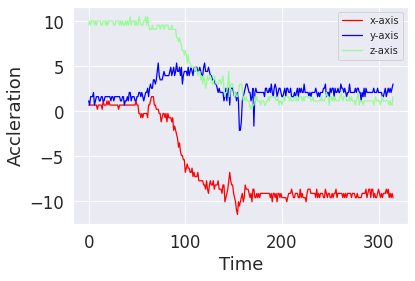

In [75]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

Rotation


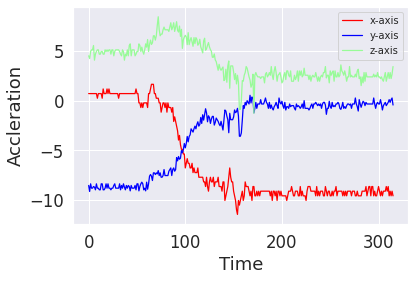

In [76]:
rotated_sample = DA.DA_Rotation_specific(SAMPLE.transpose(), ANGLE_LOW, ANGLE_HIGH, AXIS).transpose()
print("Rotation")
graph_numpy(rotated_sample)

*   In this examples, we rotate around the ```x axis``` between ```-pi/2``` and ```pi/2``` (-90 to 90 degrees) 



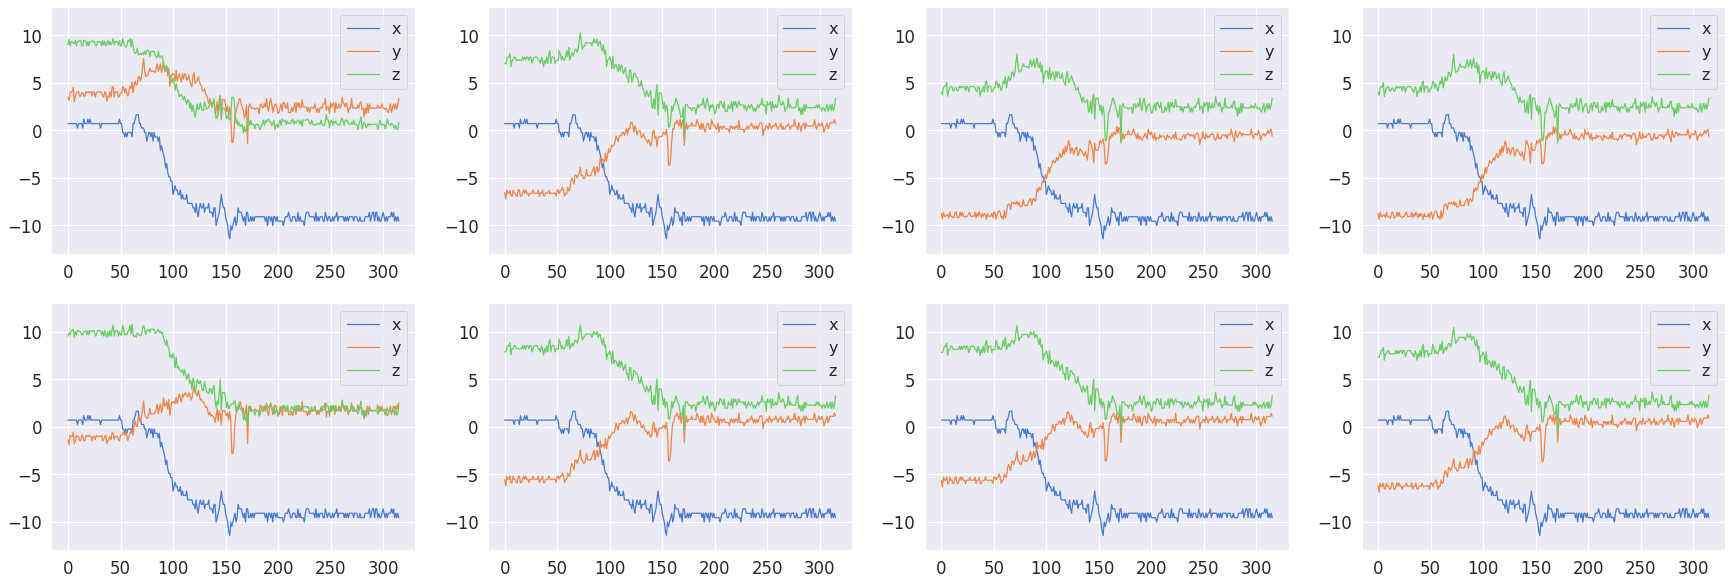

In [77]:
fig = plt.figure(figsize=(30,10))

for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    rotated = (DA.DA_Rotation_specific(SAMPLE.transpose(), ANGLE_LOW, ANGLE_HIGH, AXIS))
    ax.set_ylim([-13, 13])
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})